<a href="https://colab.research.google.com/github/YunhwanJacobLee/AIFFEL_quest_cr/blob/main/Main_Quest/Quest_03/Main_Quest_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 폐렴 진단

# 목차

## 1. 폐렴 진단 (CNN)
1. 데이터셋
2. 셋업
3. CNN 모델링
4. 모델 훈련
5. 결과 확인

## 2. 폐렴 진단기 개선 (ResNet 16)
1. 실험 환경 셋업
2. 데이터 준비 (Augmentaion)
3. 데이터 시각화
4. ResNet-18 구현
5. 모델 훈련
6. 결과 확인 및 시각화

## 3. 회고

## 1. 폐렴 진단 (CNN)

### 1) 데이터셋
*   캐글의 Chest X-ray Images
*   하위 3개(train, val, test)의 폴더로 구성되며, 각 폴더는 폐렴/정상에 대한 하위 폴더로 구성
*   총 5,856개의 X-ray 이미지
*   중국 광저우의 1~5 세 소아 환자의 흉부 X-ray

폐렴의 구별법은 언뜻 예상외로 간단합니다.   
X-RAY 사진상, 다양한 양상의 음영(폐 부위에 희미한 그림자) 증가가 관찰됩니다.   
구별 방법은 간단하지만 실제로 영상을 보면 희미한 경우가 많이 있어 저게 실제로 폐렴으로 인한 것인지 아니면 다른 이유 때문인지 파악하기 어렵습니다.

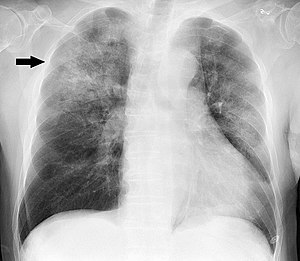

정상적인 흉부 X-RAY(왼쪽)는 이미지에서 비정상적인 음영 영역이 없는 깨끗한 폐를 보여줍니다.   
세균성 폐렴 (가운데)은 일반적으로 오른쪽 상부 엽 (흰색 화살표)에 있는 나타내는 반면, 바이러스성 폐렴 (오른쪽)은 양쪽 폐에서보다 확산된 "interstitial(조직 사이에 있는)" 패턴으로 나타납니다.   

위와 같이 폐렴에 걸린 사진들은 특징이 패턴을 이루고 있는 것을 볼 수 있습니다.   
이런 패턴을 잘 읽어내는 딥러닝 알고리즘은 충분히 학습 시킬 수 있을 것 같죠?   
딥러닝 알고리즘들이 패턴인식 알고리즘의 일종이라고 부르는 것처럼,
이 이미지에서 폐렴의 특징 패턴을 학습해서 찾아내게 시키면 됩니다.

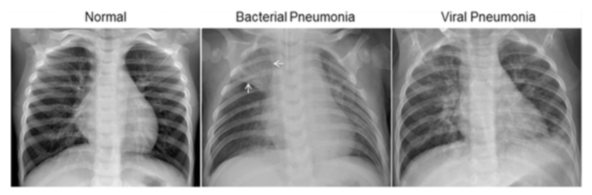

### 2) 셋업

In [39]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [40]:
#캐글에서 데이터 가져오기
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [41]:
import kagglehub
import os
import glob

# Kaggle 데이터 다운로드
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

# 데이터 경로 설정
ROOT_PATH = os.path.join(path, "chest_xray")  # 다운로드된 데이터의 기본 경로
TRAIN_PATH = os.path.join(ROOT_PATH, "train", "*", "*")  # 학습 데이터
VAL_PATH = os.path.join(ROOT_PATH, "val", "*", "*")  # 검증 데이터
TEST_PATH = os.path.join(ROOT_PATH, "test", "*", "*")  # 테스트 데이터

# 데이터 로드 설정
BATCH_SIZE = 16
EPOCHS = 10
IMAGE_SIZE = [180, 180]
AUTOTUNE = tf.data.experimental.AUTOTUNE

print("ROOT_PATH:", ROOT_PATH)
print("TRAIN_PATH:", TRAIN_PATH)
print("VAL_PATH:", VAL_PATH)
print("TEST_PATH:", TEST_PATH)


ROOT_PATH: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray
TRAIN_PATH: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/*/*
VAL_PATH: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val/*/*
TEST_PATH: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/*/*


In [42]:
# 개수 비는 89%, 10.7%, 0.3%. val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 가져옴.

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [43]:
# train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할.
# train 데이터와 validation 데이터를 모두 filenames에 담기.
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [44]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/NORMAL2-IM-1175-0001.jpeg
Pneumonia image path
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person1457_virus_2498.jpeg


In [45]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [46]:
# 대량의 데이터 처리 성능을 최적화하고, 모델 학습을 효율적으로 수행하기 위해 tf.data.Dataset 형식으로 변환하여 데이터 파이프라인을 구축
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [47]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [10]:
# # 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분 가능

# # file_path1 = "/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/IM-0703-0001.jpeg"
# # file+path2 = "/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person1425_virus_2438.jpeg"

# # parts = tf.strings.split(file_path, os.path.sep) - os.path.sep = 구분 기준
# # # file_path1 결과: ['root', '.....', 'chest_xray', 'train', 'NORMAL', 'IM-0703-0001.jpeg']

# def get_label(file_path):
#     parts = tf.strings.split(file_path, os.path.sep)
#     return parts[-2] == "PNEUMONIA"   # 끝에서 두번 째가 폐렴(PNEUMONIA)이면 양성(True), 노말(NORMAL)이면 음성(False)

In [48]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return tf.cast(parts[-2] == "PNEUMONIA", tf.int32)  # 🔹 반드시 int32 변환

In [49]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [50]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [51]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


In [52]:
# 테스트도 위 과정 적용
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [53]:
def prepare_for_training(ds, shuffle_buffer_size=1000): # buffer_size 크기(1000개 샘플)만큼 메모리에 데이터를 보관하면서 무작위로 섞음.
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat() # 데이터셋을 무한 반복하여 epochs 동안 계속 사용할 수 있도록 함.
    ds = ds.batch(BATCH_SIZE) # 배치 단위(BATCH_SIZE 개수)로 묶어 학습 속도를 높임.
    ds = ds.prefetch(buffer_size=AUTOTUNE) # TensorFlow가 미리 다음 배치를 로딩하여 데이터 로딩 속도를 최적화.
    # 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 3) 데이터 시각화

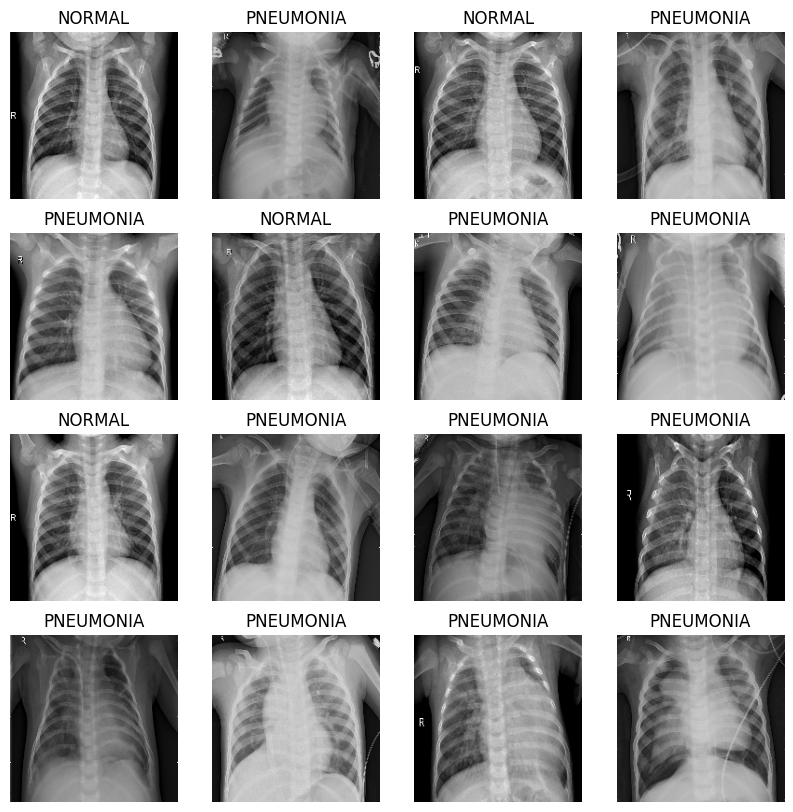

In [17]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### 4) CNN 모델링

In [18]:
# CNN 블럭 함수
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

In [31]:
# dense 블럭 함수
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [20]:
# 모델 쌓기
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [54]:
# 데이터 imbalace 문제: weight balancing 샘플 개수가 적은 클래스가 상대적으로 더 높은 가중치를 갖도록 조정됨

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### 5) 모델 훈련

In [22]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [35]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 104s 260ms/step - accuracy: 0.7700 - loss: 0.4933 - precision: 0.9362 - recall: 0.7414 - val_accuracy: 0.7346 - val_loss: 0.7419 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 80s 308ms/step - accuracy: 0.8980 - loss: 0.2602 - precision: 0.9697 - recall: 0.8925 - val_accuracy: 0.7356 - val_loss: 1.2545 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 81s 312ms/step - accuracy: 0.9249 - loss: 0.1942 - precision: 0.9753 - recall: 0.9228 - val_accuracy: 0.7837 - val_loss: 0.4708 - val_precision: 0.9927 - val_recall: 0.7107
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 82s 314ms/step - accuracy: 0.9188 - loss: 0.2173 - precision: 0.9645 - recall: 0.9237 - val_accuracy: 0.9577 - val_loss: 0.1051 - val_precision: 0.9775 - val_recall: 0.9647
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 82s 316ms/step - accuracy: 0.9271 - loss: 0.1956 - precision: 0.9742 - recall: 0.9246 - val_accuracy: 0.964

### 6) 결과 확인

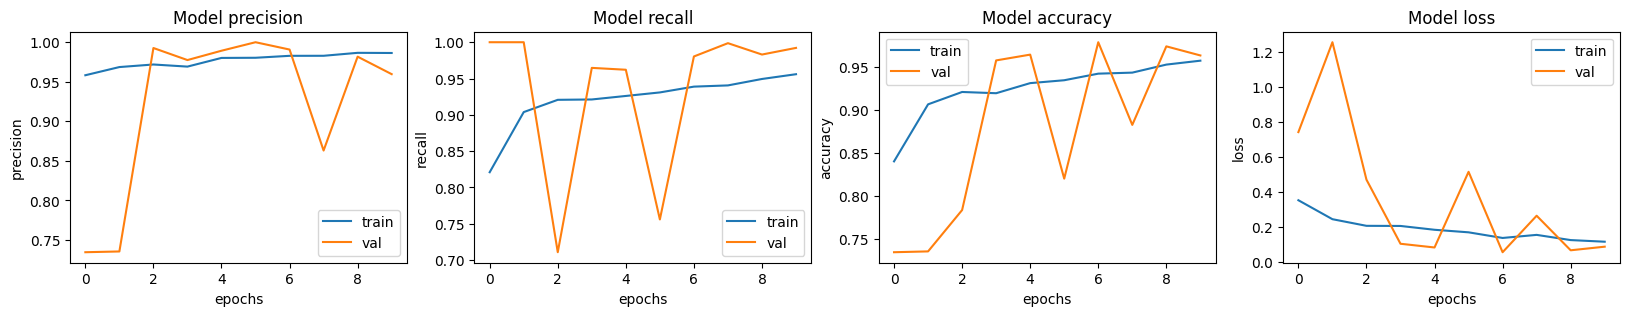

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [37]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.7314 - loss: 1.0329 - precision: 0.7113 - recall: 1.0000
Loss: 1.1247588396072388,
Accuracy: 0.7035256624221802,
Precision: 0.678260862827301,
Recall: 1.0


## 2. 폐렴 진단기 성능 개선 (ResNet 16)

### 1) 실험환경 셋업

In [55]:
import tensorflow

print(tensorflow.__version__)

2.18.0


In [64]:
BATCH_SIZE = 16
EPOCHS = 10
IMAGE_SIZE = [180, 180]
AUTOTUNE = tf.data.experimental.AUTOTUNE

### 2) 데이터 준비 (augmentation)

In [57]:
# aumentation 적용할 시 코드.
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_augment_ds = prepare_for_training(train_ds)

### 3) 데이터 시각화

TypeError: Invalid shape (16, 180, 180, 3) for image data

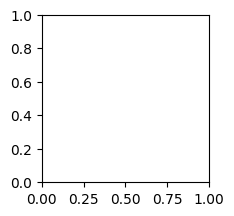

In [25]:

# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_augment_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### 4) ResNet-18 구현

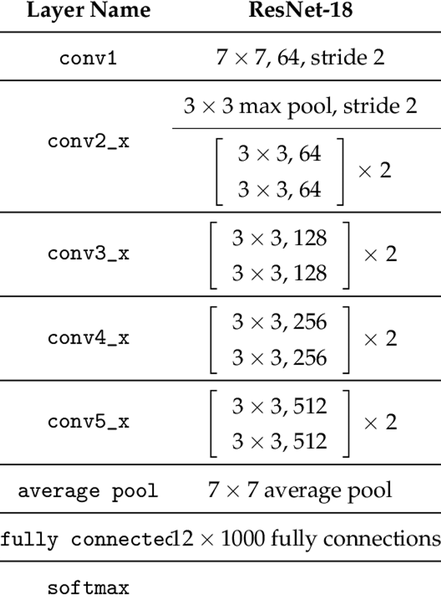

In [58]:
import tensorflow as tf
from tensorflow.keras import layers

def residual_block(input_layer, filters, downsample=False):
    """
    ResNet Residual Block
    - downsample=True: Stride=2로 크기 감소
    - downsample=False: 크기 유지
    """
    merge_input = input_layer  # Skip Connection (잔차 연결)

    # 다운샘플링이 필요하면 Stride=2 적용
    stride = 2 if downsample else 1

    # 첫 번째 Conv2D + BN + ReLU
    x = layers.Conv2D(filters, (3, 3), strides=stride, padding="same")(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 두 번째 Conv2D + BN (⚠️ ReLU 없음)
    x = layers.Conv2D(filters, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    # Skip Connection (입력값과 차원이 다르면 1x1 Conv 적용)
    if input_layer.shape[-1] != filters or downsample:
        merge_input = layers.Conv2D(filters, (1, 1), strides=stride, padding="same")(input_layer)

    x = layers.Add()([x, merge_input])  # Skip Connection
    x = layers.ReLU()(x)  # 마지막 ReLU 적용

    return x


In [59]:
def build_resnet18(input_shape=(180, 180, 3)):
    """
    ResNet-18 전체 모델 구현
    """
    inputs = layers.Input(shape=input_shape)

    # 초기 Conv + MaxPooling
    x = layers.Conv2D(64, (7, 7), strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding="same")(x)  # 크기 축소

    # Residual Blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, downsample=True)
    x = residual_block(x, 128)

    x = residual_block(x, 256, downsample=True)
    x = residual_block(x, 256)

    x = residual_block(x, 512, downsample=True)
    x = residual_block(x, 512)

    # Global Average Pooling & Fully Connected Layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, x, name="ResNet18")

    return model

# 모델 생성 및 요약 확인
model = build_resnet18()
model.summary()


Model: "ResNet18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (None, 90, 90, 64)     │          9,472 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_41    │ (None, 90, 90, 64)     │            256 │ conv2d_42[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_34 (ReLU)           │ (None, 90, 90, 64)     │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 45, 45, 64)     │              0 │ re_lu_34[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (None, 45, 45, 64)     │         36,928 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_42    │ (None, 45, 45, 64)     │            256 │ conv2d_43[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_35 (ReLU)           │ (None, 45, 45, 64)     │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 45, 45, 64)     │         36,928 │ re_lu_35[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_43    │ (None, 45, 45, 64)     │            256 │ conv2d_44[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_16 (Add)              │ (None, 45, 45, 64)     │              0 │ batch_normalization_4… │
│                           │                        │                │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_36 (ReLU)           │ (None, 45, 45, 64)     │              0 │ add_16[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 45, 45, 64)     │         36,928 │ re_lu_36[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_44    │ (None, 45, 45, 64)     │            256 │ conv2d_45[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_37 (ReLU)           │ (None, 45, 45, 64)     │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_46 (Conv2D)        │ (None, 45, 45, 64)     │         36,928 │ re_lu_37[0][0]         │
├──────────────────────

 Total params: 11,187,841 (42.68 MB)

 Trainable params: 11,180,033 (42.65 MB)

 Non-trainable params: 7,808 (30.50 KB)

In [36]:
# 데이터 imbalace 문제: weight balancing 샘플 개수가 적은 클래스가 상대적으로 더 높은 가중치를 갖도록 조정됨

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### 5) 모델 훈련

In [65]:
with tf.device('/GPU:0'):
    model = build_resnet18()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [66]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 101s 268ms/step - accuracy: 0.8273 - loss: 0.5924 - precision: 0.9339 - recall: 0.8273 - val_accuracy: 0.6548 - val_loss: 0.5751 - val_precision: 0.8814 - val_recall: 0.6126
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 80s 307ms/step - accuracy: 0.9274 - loss: 0.1749 - precision: 0.9760 - recall: 0.9245 - val_accuracy: 0.9202 - val_loss: 0.2315 - val_precision: 0.9899 - val_recall: 0.9004
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 82s 316ms/step - accuracy: 0.9538 - loss: 0.1279 - precision: 0.9835 - recall: 0.9541 - val_accuracy: 0.3750 - val_loss: 2.5828 - val_precision: 1.0000 - val_recall: 0.1481
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 83s 319ms/step - accuracy: 0.9538 - loss: 0.1114 - precision: 0.9844 - recall: 0.9523 - val_accuracy: 0.8394 - val_loss: 0.4577 - val_precision: 1.0000 - val_recall: 0.7808
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 80s 309ms/step - accuracy: 0.9557 - loss: 0.1136 - precision: 0.9874 - recall: 0.9529 - val_accuracy: 0.876

### 6) 결과 확인 및 시각화

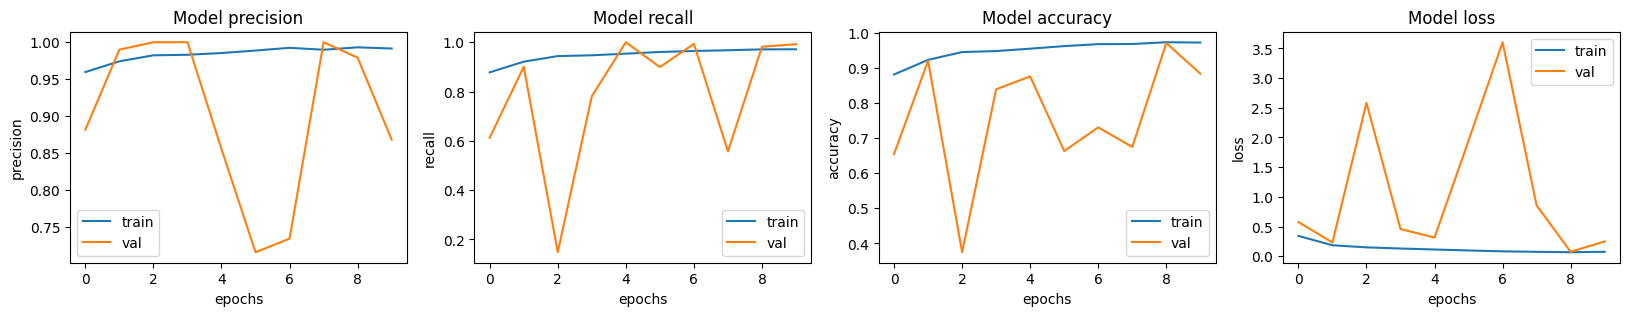

In [67]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [68]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.6731 - loss: 1.4042 - precision: 0.6607 - recall: 1.0000
Loss: 1.5121880769729614,
Accuracy: 0.6618589758872986,
Precision: 0.6489184498786926,
Recall: 1.0


## 3. 회고

* 실제 데이터를 통해 딥러닝 모델을 구축해서 돌려본 것이 좋았다.
* 하지만, 여전히 노드 등을 의존해야하고 따라가기 너무 바빴다.   
* 마지막으로, 모델을 바꾸어 돌려 보았으나 성능에 별로 차이가 나타나지 않아서 여러 시도를 해보려 했으나, 머리가 복잡해져 시도를 못했다.
* 전문가가 직접 모델을 구현하고 학습 및 튜닝하는 과정을 보면 더 도움이 될 것 같다.